In [59]:
from visualize import *

<AxesSubplot:>

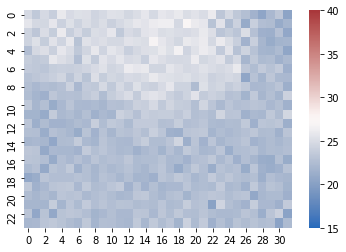

In [193]:
sns.heatmap(data[223,:,:,13] , cmap="vlag" , vmin=15 ,vmax=40)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scipy.stats as sc

In [152]:
def gaussian_pdf(x , sigma , mu):
    pdf1 = (1/(sigma*np.sqrt(2*np.pi)))
    pdf2 = np.exp(-0.5*((x-mu)/sigma)**2)
    return pdf1*pdf2
n = 0.006
mean = np.zeros((235,24,32,16))
mean[0,:,:,0] = np.copy(data[0,:,:,0])
sigma = 0.4
alpha = 0.0001
M = 0
gmean = np.zeros((235,24,32,16))
gp = np.zeros((235,24,32,16))
event = np.zeros((235,24,32,16))

for i in range(0,1):
    for j in range(0,1):
        for k in range(0,24):
            for l in range(0,32):
                event[i,k,l,j] = 1

for j in range(0,16):
    mean[0,:,:,0] = mean[0,:,:,0] + data[0,:,:,j]
for j in range(0,9):
    mean[0,:,:,0] = mean[0,:,:,0] + data[1,:,:,j]

mean[0,:,:,0] = mean[0,:,:,0]/25

fg = []
cnt = np.zeros((236,16))
bg = []
maxi = np.zeros((235,24,32,16))
mini = np.zeros((235,24,32,16))
mini[0,:,:,0] = data[0,:,:,0]
maxi[0,:,:,0] = data[0,:,:,0]
theta = 0.015
gamma = 0.2

In [153]:

for l in range(0,235):
    start = 0
    if l == 0:
        start = 1
    for k in range(start,16):
        for i in range(0,24):
            for j in range(0,32):
                if k==0:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l-1,i,j,15]*(1-alpha)        ## Mean if k==0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l-1,i,j,15] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l-1,i,j,15] , data[l,i,j,k])
                else:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l,i,j,k-1]*(1-alpha)                  ## Mean if k!=0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l,i,j,k-1] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l,i,j,k-1] , data[l,i,j,k])

                gp[l,i,j,k] = gaussian_pdf(data[l,i,j,k] , sigma , mean[l,i,j,k])                    ## Find the gaussian PDF 
                if gp[l,i,j,k]<n and data[l,i,j,k]>mean[0,i,j,0]:                                   ## Process is foreground
                    event[l,i,j,k] = 0
                    fg.append((data[l,i,j,k] , mean[l,i,j,k]))
                    if k!=0:
                        mean[l,i,j,k] = mean[l,i,j,k-1]                                       ## Update the mean if the process is foreground
                    else:
                        mean[l,i,j,k] = mean[l-1,i,j,15]

                else:
                    event[l,i,j,k] = 1   
                    bg.append((data[l,i,j,k] , mean[l,i,j,k]))                              ## Process is Background

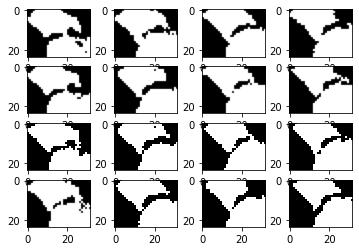

In [155]:
def visualize(second):
    fig, axs = plt.subplots(4, 4)
    frame = 0
    axs[0,0].imshow(mrf_event[second,:,:,frame] , cmap='Greys')
    axs[1,0].imshow(mrf_event[second,:,:,frame+1] , cmap='Greys')
    axs[2,0].imshow(mrf_event[second,:,:,frame+2] , cmap='Greys')
    axs[3,0].imshow(mrf_event[second,:,:,frame+3] , cmap='Greys')
    axs[0,1].imshow(mrf_event[second,:,:,frame+4] , cmap='Greys')
    axs[1,1].imshow(mrf_event[second,:,:,frame+5] , cmap='Greys')
    axs[2,1].imshow(mrf_event[second,:,:,frame+6] , cmap='Greys')
    axs[3,1].imshow(mrf_event[second,:,:,frame+7] , cmap='Greys')
    axs[0,2].imshow(mrf_event[second,:,:,frame+8] , cmap='Greys')
    axs[1,2].imshow(mrf_event[second,:,:,frame+9] , cmap='Greys')
    axs[2,2].imshow(mrf_event[second,:,:,frame+10] , cmap='Greys')
    axs[3,2].imshow(mrf_event[second,:,:,frame+11] , cmap='Greys')
    axs[0,3].imshow(mrf_event[second,:,:,frame+12] , cmap='Greys')
    axs[1,3].imshow(mrf_event[second,:,:,frame+13] , cmap='Greys')
    axs[2,3].imshow(mrf_event[second,:,:,frame+14] , cmap='Greys')
    axs[3,3].imshow(mrf_event[second,:,:,frame+15] , cmap='Greys')
visualize(210)

In [154]:
# Eradicate uncessesary foreground pixels by using the Markov Random Field model

diff = np.zeros((235,24,32,16))
mrf_event = np.zeros((235,24,32,16))
mrf_event[0,:,:,0] = 1
for l in range(0,235):
    for k in range(0,16):
        for i in range(0,24):
            for j in range(0,32):
                qf = 0
                qb = 0
                ratio = gp[l,i,j,k]*25      
                if i>0 and j>0:
                    if event[l,i-1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i>0:
                    if event[l,i-1,j,k] == 0:
                        qf = qf+1
                    else:
                        qb = qb+1
                if j<31 and i>0:
                    if event[l,i-1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j>0:
                    if event[l,i,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j<31:
                    if event[l,i,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j>0:
                    if event[l,i+1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23:
                    if event[l,i+1,j,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j<31:
                    if event[l,i+1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1

                mrf = theta * np.exp((qf-qb)/gamma)
                if ratio < mrf and data[l,i,j,k] > mean[l,i,j,k] and data[l,i,j,k] > mean[0,i,j,0]:
                    mrf_event[l,i,j,k] = 0
                    cnt[l,k] = cnt[l,k] + 1
                else:
                    mrf_event[l,i,j,k] = 1
                diff[l,i,j,k] = ratio-mrf


In [74]:
for l in range(0,235):
    for k in range(0,16):
        if cnt[l,k] > 100:
            print(l,k)


10 15
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
12 0
12 1
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
41 4
41 5
41 6
41 7
41 8
41 9
41 10
41 11
41 12
41 13
41 14
41 15
54 2
54 4
54 5
54 6
54 7
54 8
54 9
54 10
54 11
54 12
54 13
54 14
54 15
55 0
55 1
55 2
55 3
55 4
55 5
55 6
55 7
55 8
55 9
55 10
55 11
55 12
55 13
55 14
55 15
56 0
56 1
56 2
56 3
56 4
56 5
56 6
56 7
56 8
56 9
56 10
56 11
56 12
56 13
56 14
56 15
58 5
58 6
58 7
58 8
58 9
58 10
58 11
58 12
58 13
58 14
58 15
59 0
59 1
59 2
59 3
59 4
59 5
59 6
59 7
59 8
59 9
59 10
59 11
77 12
77 13
77 14
77 15
78 0
78 1
78 2
78 3
78 4
91 12
91 13
91 14
91 15
92 0
92 1
92 2
92 3
92 4
92 5
92 6
92 7
92 8
92 9
92 10
92 11
92 12
92 13
92 14
92 15
93 0
93 1
93 2
93 3
93 4
93 5
93 6
93 7
93 8
93 9
93 10
93 11
93 12
93 13
93 14
93 15
94 0
103 5
103 6
103 7
103 8
103 9
103 10
103 11
103 12
103 13
103 14
103 15
104 0
104 1
104 2
104 3
104 4
106 3
106 4
106 

In [188]:
cnt[223,10]

273.0

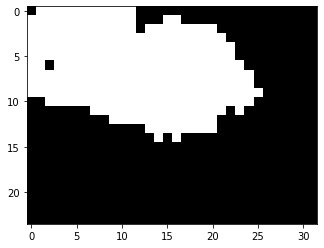

In [189]:
plt.imshow(mrf_event[223,:,:,10] , cmap='Greys')

In [158]:
# Blob detection
# Use Recursive Blob Detection method (Similar to DBSCAN)
L = 100
K = 100
def blob_detector(i, j, visited, color, second, frame):
    '''
    Given a frame after BS, detects "blobs"
    '''
    
    blob_size = 1
    if visited[i,j] != 0 or mrf_event[second,i,j,frame] == 1:
        return 0
    
    record.append((i,j,color))
    visited[i,j] = color
    connected = 0
    if i>0 and j>0 and mrf_event[second,i-1,j-1,frame] == 0 and visited[i-1,j-1] == 0:
        blob_size = blob_size + blob_detector(i-1,j-1,visited,color,second,frame)
        connected = connected + 1
        
    if i>0 and mrf_event[second,i-1,j,frame] == 0 and visited[i-1,j] == 0:
        blob_size  = blob_size + blob_detector(i-1,j,visited,color,second,frame)
        connected = connected + 1
       
    if j<31 and i>0 and mrf_event[second,i-1,j+1,frame] == 0 and visited[i-1,j+1] == 0:
        blob_size  = blob_size + blob_detector(i-1,j+1,visited,color,second,frame)
        connected = connected + 1
       
    if j>0 and mrf_event[second,i,j-1,frame] == 0 and visited[i,j-1] == 0:
        blob_size  = blob_size + blob_detector(i,j-1,visited,color,second,frame)
        connected = connected + 1
       
    if j<31 and mrf_event[second,i,j+1,frame] == 0 and visited[i,j+1] == 0:
        blob_size  = blob_size + blob_detector(i,j+1,visited,color,second,frame)
        connected = connected + 1
        
    if i<23 and j>0 and mrf_event[second,i+1,j-1,frame] == 0 and visited[i+1,j-1] == 0:
        blob_size  = blob_size + blob_detector(i+1,j-1,visited,color,second,frame)
        connected = connected + 1
       
    if i<23 and mrf_event[second,i+1,j,frame] == 0 and visited[i+1,j] == 0:
        blob_size  = blob_size + blob_detector(i+1,j,visited,color,second,frame)
        connected = connected + 1
       
    if i<23 and j<31 and mrf_event[second,i+1,j+1,frame] == 0 and visited[i+1,j+1] == 0:
        blob_size  = blob_size + blob_detector(i+1,j+1,visited,color,second,frame)
        connected = connected + 1
  
    return blob_size

visited = np.zeros((24,32))
blobs = []
record = []
color = 1
for i in range(0,24):
    for j in range(0,32):
        size = blob_detector(i,j,visited,color,10,15)
        if size>100:
            blobs.append((i,j,size))
            color = color+1
        




In [159]:
print("Blobs" , blobs)
print("Record Shape" , np.shape(record))

Blobs [(0, 0, 143)]
Record Shape (143, 3)


In [160]:
blobs = []
for l in range(0,235):
    for k in range(0,16):
        if cnt[l,k] < K:
            continue
        record = []
        color = 1
        visited = np.zeros((24,32))
        for i in range(0,24):
            for j in range(0,32):
                size = blob_detector(i,j,visited,color,l,k)
                if size>=L:
                    color = color + 1
        blobs.append((l,k,color-1,record))

In [161]:
cnt[11,2]

201.0

In [162]:
print(blobs[0][1])

15


In [187]:
input1 = int(input("Enter second"))
input2 = int(input("Enter frame"))
print("----------------------------------------------")
print("-------------Blob information-----------------")
print("Second: " , input1)
print("Frame: ", input2)
flag = -1
for i in range(len(blobs)):
    if blobs[i][0] == input1-1 and blobs[i][1] == input2-1:
        flag = i

if flag == -1:
    print("No blobs in the requested frame!")
else:
    print("Number of Blobs: " , blobs[flag][2])
    print("Blob indices along with their color: " , blobs[flag][3])
print("----------------------------------------------")

----------------------------------------------
-------------Blob information-----------------
Second:  211
Frame:  16
Number of Blobs:  2
Blob indices along with their color:  [(0, 5, 1), (0, 6, 1), (0, 7, 1), (0, 8, 1), (0, 9, 1), (0, 10, 1), (0, 11, 1), (0, 12, 1), (0, 13, 1), (0, 14, 1), (0, 15, 1), (0, 16, 1), (0, 17, 1), (0, 18, 1), (0, 19, 1), (0, 20, 1), (1, 19, 1), (1, 18, 1), (1, 17, 1), (1, 16, 1), (1, 15, 1), (1, 14, 1), (1, 13, 1), (1, 12, 1), (1, 11, 1), (1, 10, 1), (1, 9, 1), (1, 8, 1), (1, 7, 1), (1, 6, 1), (1, 5, 1), (1, 4, 1), (2, 3, 1), (2, 2, 1), (3, 2, 1), (3, 3, 1), (2, 4, 1), (2, 5, 1), (2, 6, 1), (2, 7, 1), (2, 8, 1), (2, 9, 1), (2, 10, 1), (2, 11, 1), (2, 12, 1), (2, 13, 1), (2, 14, 1), (2, 15, 1), (2, 16, 1), (2, 17, 1), (2, 18, 1), (2, 19, 1), (1, 20, 1), (1, 21, 1), (2, 20, 1), (2, 21, 1), (2, 22, 1), (3, 21, 1), (3, 20, 1), (3, 19, 1), (3, 18, 1), (3, 17, 1), (3, 16, 1), (3, 15, 1), (3, 14, 1), (3, 13, 1), (3, 12, 1), (3, 11, 1), (3, 10, 1), (3, 9, 1), (3, 8

In [175]:
# Use the obtained information in order to calculate centroid
# For a given frame, in order to calculate the centroid, we get the information on how many blobs are present

blob_frames = np.shape(blobs)[0]
centroids = []

for i in range(0,blob_frames):
    colors = blobs[i][2]
    j = 1
    frame_centroids = []
    while j <= colors:
        local_centroid_x = 0
        local_centroid_y = 0
        numb = 0
        for k in range(0,len(blobs[i][3])):
            if blobs[i][3][k][2] == j:
                local_centroid_x = local_centroid_x + blobs[i][3][k][0]
                local_centroid_y = local_centroid_y + blobs[i][3][k][1]
                numb = numb + 1
        local_centroid_x = local_centroid_x/numb
        local_centroid_y = local_centroid_y/numb
        frame_centroids.append((j , local_centroid_x , local_centroid_y))
        j = j+1
    centroids.append((blobs[i][0],blobs[i][1],blobs[i][2],frame_centroids))





In [184]:
centroids[80]

(213, 6, 1, [(1, 11.80982905982906, 18.03846153846154)])

In [196]:
print(centroids[0])

(10, 15, 1, [(1, 5.993006993006993, 5.090909090909091)])


In [ ]:

print(len(centroids))
for i in range(1,len(centroids)-1):
    second = centroids[i][0]
    frame = centroids[1]
    if second != centroids[i-1][0] or second != centroids[i+1][0]:
        if (centroids[i-1][1] == 15 and frame == 0) or (centroids[i+1][1] == 0 and frame == 15):
            continue
        elif np.abs(centroids[i-1][0] - seconds) > 1 and np.abs(centroids[i+1][0] - seconds) > 1:
            centroids.remove(centroids[i])
            continue
    elif frame != centroids[i-1][1] + 1 or frame != centroids[i+1][1] - 1:
        if (np.abs(centroids[i-1][1] - frame) > 10 and np.abs(cnt[centroids[i-1][0] , centroids[i-1][1]] - cnt[second , frame]) > 100) or (np.abs(centroids[i+1][1] - frame) > 10 and np.abs(cnt[centroids[i+1][0] , centroids[i+1][1]] - cnt[second , frame]) > 100):
            centroids.remove(centroids[i])
    



        